In [34]:
#bert-base-uncased

In [31]:
import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from tqdm.notebook import tqdm
import time
import random

# Load the dataset
with open('Combined_training.json', 'r') as f:
    data = json.load(f)

# Prepare the data for training
intents = data['intents']
texts = []
labels = []
responses_dict = {}

for intent in intents:
    responses_dict[intent['tag']] = intent['responses']
    for pattern in intent['patterns']:
        texts.append(pattern)
        labels.append(intent['tag'])

df = pd.DataFrame({'text': texts, 'label': labels})

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_function(texts, max_length=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

tokens = tokenize_function(df['text'].tolist())

class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
EPOCHS = 10
MAX_LENGTH = 128
N_SPLITS = 5

# K-Fold Cross Validation
skf = StratifiedKFold(n_splits=N_SPLITS)
fold = 0

# Store metrics for each epoch
all_folds_metrics = []

# Store overall metrics
overall_accuracy = []
overall_f1 = []
overall_precision = []
overall_recall = []
overall_train_loss = []
overall_val_loss = []
overall_train_time = []

for train_index, val_index in skf.split(df['text'], df['label']):
    fold += 1
    print(f"Fold {fold}")

    train_texts, val_texts = df['text'].iloc[train_index].tolist(), df['text'].iloc[val_index].tolist()
    train_labels, val_labels = df['label'].iloc[train_index].tolist(), df['label'].iloc[val_index].tolist()

    train_tokens = tokenize_function(train_texts, max_length=MAX_LENGTH)
    val_tokens = tokenize_function(val_texts, max_length=MAX_LENGTH)

    train_dataset = IntentDataset(train_tokens, train_labels)
    val_dataset = IntentDataset(val_tokens, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    model.to(device)

    fold_train_loss = []
    fold_val_loss = []
    fold_train_time = []
    epoch_metrics = []

    for epoch in tqdm(range(EPOCHS), desc="Epochs", leave=False):
        model.train()
        start_time = time.time()
        train_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        fold_train_loss.append(train_loss)

        model.eval()
        val_loss = 0
        val_labels_all = []
        val_preds_all = []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                val_loss += loss.item()
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                val_labels_all.extend(batch['labels'].cpu().numpy())
                val_preds_all.extend(preds)

        val_loss /= len(val_loader)
        fold_val_loss.append(val_loss)
        val_accuracy = accuracy_score(val_labels_all, val_preds_all)
        val_f1 = f1_score(val_labels_all, val_preds_all, average='weighted')
        val_precision = precision_score(val_labels_all, val_preds_all, average='weighted', zero_division=1)
        val_recall = recall_score(val_labels_all, val_preds_all, average='weighted')

        end_time = time.time()
        epoch_time = end_time - start_time
        fold_train_time.append(epoch_time)

        epoch_metrics.append([
            epoch + 1, train_loss, val_loss, val_accuracy, val_f1, val_precision, val_recall
        ])

    df_metrics = pd.DataFrame(epoch_metrics, columns=['Epoch', 'Train Loss', 'Validation Loss', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
    all_folds_metrics.append(df_metrics)

    overall_accuracy.append(val_accuracy)
    overall_f1.append(val_f1)
    overall_precision.append(val_precision)
    overall_recall.append(val_recall)
    overall_train_loss.extend(fold_train_loss)
    overall_val_loss.extend(fold_val_loss)
    overall_train_time.extend(fold_train_time)

Fold 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
# Display metrics for all folds
from IPython.display import display

for i, df in enumerate(all_folds_metrics, start=1):
    print(f"\nMetrics for Fold {i}:")
    display(df)

# Calculate average metrics
average_accuracy = sum(overall_accuracy) / len(overall_accuracy) * 100
average_f1 = sum(overall_f1) / len(overall_f1) * 100
average_precision = sum(overall_precision) / len(overall_precision) * 100
average_recall = sum(overall_recall) / len(overall_recall) * 100
average_train_loss = sum(overall_train_loss) / len(overall_train_loss)
average_val_loss = sum(overall_val_loss) / len(overall_val_loss)
average_train_time = sum(overall_train_time) / len(overall_train_time)

# Print average metrics
print(f"\nAverage Metrics over {N_SPLITS} Folds:")
print(f"Average Accuracy: {average_accuracy:.2f}%")
print(f"Average F1: {average_f1:.2f}%")
print(f"Average Precision: {average_precision:.2f}%")
print(f"Average Recall: {average_recall:.2f}%")
print(f"Average Training Loss: {average_train_loss:.6f}")
print(f"Average Validation Loss: {average_val_loss:.6f}")
print(f"Average Training Time per Epoch: {average_train_time:.2f}s")


Metrics for Fold 1:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.766957,2.528700,0.190476,0.088813,0.678968,0.190476
1,2,2.399997,2.277178,0.285714,0.170068,0.761183,0.285714
2,3,2.181147,2.054876,0.476190,0.369048,0.856009,0.476190
3,4,1.917798,1.869077,0.714286,0.646032,0.908730,0.714286
4,5,1.733675,1.673566,0.857143,0.833333,0.944444,0.857143
5,6,1.634765,1.493110,0.904762,0.880952,0.968254,0.904762
6,7,1.376336,1.298146,0.857143,0.817460,0.944444,0.857143
7,8,1.105087,1.116324,0.952381,0.936508,0.976190,0.952381
8,9,0.961553,0.950685,1.000000,1.000000,1.000000,1.000000
9,10,0.786554,0.797888,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 2:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.752922,2.529570,0.380952,0.239683,0.813492,0.380952
1,2,2.540851,2.426928,0.428571,0.280220,0.796825,0.428571
2,3,2.275559,2.113851,0.809524,0.761905,0.904762,0.809524
3,4,1.893212,1.747190,0.857143,0.828571,0.964286,0.857143
4,5,1.610669,1.517150,0.857143,0.828571,0.964286,0.857143
5,6,1.364074,1.200459,1.000000,1.000000,1.000000,1.000000
6,7,1.118681,1.011078,1.000000,1.000000,1.000000,1.000000
7,8,0.922586,0.755802,1.000000,1.000000,1.000000,1.000000
8,9,0.707297,0.586456,1.000000,1.000000,1.000000,1.000000
9,10,0.561275,0.471570,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 3:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.806523,2.717876,0.095238,0.024845,0.776190,0.095238
1,2,2.659163,2.559540,0.142857,0.050420,0.697279,0.142857
2,3,2.344963,2.623707,0.285714,0.210317,0.804329,0.285714
3,4,2.135385,2.140284,0.523810,0.431973,0.797619,0.523810
4,5,1.950807,1.898006,0.571429,0.511905,0.879819,0.571429
5,6,1.809369,1.678605,0.714286,0.646032,0.908730,0.714286
6,7,1.522616,1.492844,0.761905,0.714286,0.888889,0.761905
7,8,1.437434,1.208520,0.809524,0.746032,0.904762,0.809524
8,9,1.179073,1.001346,0.952381,0.952381,0.976190,0.952381
9,10,1.027371,0.805870,0.952381,0.952381,0.976190,0.952381



Metrics for Fold 4:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.781147,2.529757,0.238095,0.129870,0.802116,0.238095
1,2,2.473255,2.243260,0.380952,0.339342,0.711565,0.380952
2,3,2.212186,2.038472,0.904762,0.896825,0.968254,0.904762
3,4,1.911691,1.800249,0.952381,0.936508,0.976190,0.952381
4,5,1.664484,1.581380,1.000000,1.000000,1.000000,1.000000
5,6,1.364955,1.367418,1.000000,1.000000,1.000000,1.000000
6,7,1.241119,1.159083,1.000000,1.000000,1.000000,1.000000
7,8,1.009305,0.975243,1.000000,1.000000,1.000000,1.000000
8,9,0.826926,0.889507,1.000000,1.000000,1.000000,1.000000
9,10,0.712877,0.763721,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 5:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.786497,2.567884,0.142857,0.085317,0.741270,0.142857
1,2,2.403532,2.288874,0.428571,0.309524,0.738095,0.428571
2,3,2.340295,2.098495,0.571429,0.449206,0.825397,0.571429
3,4,2.104598,1.892617,0.714286,0.647619,0.880952,0.714286
4,5,1.838364,1.699270,0.761905,0.674830,0.861111,0.761905
5,6,1.584347,1.391646,0.857143,0.817460,0.944444,0.857143
6,7,1.322803,1.284576,0.904762,0.880952,0.968254,0.904762
7,8,1.128795,1.077043,0.904762,0.880952,0.968254,0.904762
8,9,0.951613,0.913835,0.904762,0.880952,0.968254,0.904762
9,10,0.782961,0.748990,0.952381,0.952381,0.976190,0.952381



Average Metrics over 5 Folds:
Average Accuracy: 98.10%
Average F1: 98.10%
Average Precision: 99.05%
Average Recall: 98.10%
Average Training Loss: 1.698509
Average Validation Loss: 1.597150
Average Training Time per Epoch: 2.98s


In [33]:
# Function to get a response from the model
def get_response(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()
    intent = label_encoder.inverse_transform([predicted_class_id])[0]
    response = random.choice(responses_dict[intent])
    return response

# Interactive chat
print("Start chatting with the bot (type 'quit' to stop)!")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    response = get_response(user_input)
    print(f"Bot: {response}")

Start chatting with the bot (type 'quit' to stop)!


You:  hi


Bot: Good day! What do you need help with?


You:  how are you


Bot: Hey! How can I help?


You:  tell me stance on si tools


Bot: The University's academic integrity policy (UPR AS14 Appendix III) [https://www.herts.ac.uk/__data/assets/pdf_file/0007/237625/AS14-Apx3-Academic-Misconduct-v17.0.pdf]sets out our stance on plagiarism including fake referencing which can often be the case with AI tools. Therefore, it is crucial thatyou do not use AI toolsto generate an assessment and submit it as your own work; to do so will constitute academic misconduct.


You:  what is artificial intelligence


Bot: Information about the University's policy on the use of artificial intelligence tools. Artificial intelligence tools (AI) have had lots of coverage in the news recently including how they can be used in workplaces and universities. You may have heard of tools such as Chat GPT, DALLE-2, Co-Pilot, and Google Bard although there are many more available for different purposes. When it comes to your course, inappropriate use of these tools can negatively impact your learning as well as affecting your own confidence in your qualification and ability. While such tools may seem like time-savers, their potential and limitations are still not fully explored. So far, we know that some materials/information may be out of date or incorrect, and some of the information may be fictitious or contain false references and quotes. We're also aware that since AI models are trained on the data that they are exposed to, this can result in biases. So, responses or information you pull out of such tools 

You:  when i can use ai 


Bot: The only occasions where you may use AI tools in your assessment is if you have explicit permission from your tutor in your assessment brief. Your assessment brief will include information on how to declare any use of such tools, and you can speak to your tutor for guidance. If you do not reference your use, then this will constitute academic misconduct. Our current University policy on academic misconduct adequately covers the misuse of such tools, but we are updating them to be clearer on the matter. Unauthorised use of artificially generated material (AI) in researching or presenting material for an assessment is an academic misconduct offence if you use AI tools in producing your assessment unless the use of AI tools is expressly permitted. However, even if expressly permitted, where you do not declare that you have used an artificial intelligence tool(s) in the production of your assessment, or you are dishonest about the extent to which such tools have been used, you will ha

You:  quit


In [ ]:
#distilbert-base-uncased

In [35]:
import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from tqdm.notebook import tqdm
import time
import random

# Load the dataset
with open('Combined_training.json', 'r') as f:
    data = json.load(f)

# Prepare the data for training
intents = data['intents']
texts = []
labels = []
responses_dict = {}

for intent in intents:
    responses_dict[intent['tag']] = intent['responses']
    for pattern in intent['patterns']:
        texts.append(pattern)
        labels.append(intent['tag'])

df = pd.DataFrame({'text': texts, 'label': labels})

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

# Tokenize the data
def tokenize_function(texts, max_length=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

tokens = tokenize_function(df['text'].tolist())

class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
EPOCHS = 10
MAX_LENGTH = 128
N_SPLITS = 5

# K-Fold Cross Validation
skf = StratifiedKFold(n_splits=N_SPLITS)
fold = 0

# Store metrics for each epoch
all_folds_metrics = []

# Store overall metrics
overall_accuracy = []
overall_f1 = []
overall_precision = []
overall_recall = []
overall_train_loss = []
overall_val_loss = []
overall_train_time = []

for train_index, val_index in skf.split(df['text'], df['label']):
    fold += 1
    print(f"Fold {fold}")

    train_texts, val_texts = df['text'].iloc[train_index].tolist(), df['text'].iloc[val_index].tolist()
    train_labels, val_labels = df['label'].iloc[train_index].tolist(), df['label'].iloc[val_index].tolist()

    train_tokens = tokenize_function(train_texts, max_length=MAX_LENGTH)
    val_tokens = tokenize_function(val_texts, max_length=MAX_LENGTH)

    train_dataset = IntentDataset(train_tokens, train_labels)
    val_dataset = IntentDataset(val_tokens, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = BertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    model.to(device)

    fold_train_loss = []
    fold_val_loss = []
    fold_train_time = []
    epoch_metrics = []

    for epoch in tqdm(range(EPOCHS), desc="Epochs", leave=False):
        model.train()
        start_time = time.time()
        train_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        fold_train_loss.append(train_loss)

        model.eval()
        val_loss = 0
        val_labels_all = []
        val_preds_all = []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                val_loss += loss.item()
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                val_labels_all.extend(batch['labels'].cpu().numpy())
                val_preds_all.extend(preds)

        val_loss /= len(val_loader)
        fold_val_loss.append(val_loss)
        val_accuracy = accuracy_score(val_labels_all, val_preds_all)
        val_f1 = f1_score(val_labels_all, val_preds_all, average='weighted')
        val_precision = precision_score(val_labels_all, val_preds_all, average='weighted', zero_division=1)
        val_recall = recall_score(val_labels_all, val_preds_all, average='weighted')

        end_time = time.time()
        epoch_time = end_time - start_time
        fold_train_time.append(epoch_time)

        epoch_metrics.append([
            epoch + 1, train_loss, val_loss, val_accuracy, val_f1, val_precision, val_recall
        ])

    df_metrics = pd.DataFrame(epoch_metrics, columns=['Epoch', 'Train Loss', 'Validation Loss', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
    all_folds_metrics.append(df_metrics)

    overall_accuracy.append(val_accuracy)
    overall_f1.append(val_f1)
    overall_precision.append(val_precision)
    overall_recall.append(val_recall)
    overall_train_loss.extend(fold_train_loss)
    overall_val_loss.extend(fold_val_loss)
    overall_train_time.extend(fold_train_time)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Fold 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerN

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 2


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 3


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Fold 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerN

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Fold 5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerN

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
# Display metrics for all folds
from IPython.display import display

for i, df in enumerate(all_folds_metrics, start=1):
    print(f"\nMetrics for Fold {i}:")
    display(df)


Metrics for Fold 1:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,3.007982,2.804012,0.142857,0.035714,0.877551,0.142857
1,2,2.759282,2.751078,0.142857,0.035714,0.877551,0.142857
2,3,2.620416,2.533121,0.190476,0.128051,0.872024,0.190476
3,4,2.253254,2.070043,0.333333,0.339683,0.908163,0.333333
4,5,1.751582,1.962321,0.428571,0.413420,0.877778,0.428571
5,6,1.283862,1.375877,0.571429,0.523243,0.891723,0.571429
6,7,0.854792,0.937205,0.761905,0.706349,0.896825,0.761905
7,8,0.600242,0.841551,0.809524,0.766667,0.912698,0.809524
8,9,0.364583,0.566599,0.857143,0.841270,0.928571,0.857143
9,10,0.234631,0.423400,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 2:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.817057,2.957342,0.142857,0.035714,0.877551,0.142857
1,2,2.734687,2.653947,0.095238,0.032813,0.879167,0.095238
2,3,2.266196,2.273230,0.238095,0.123810,0.802910,0.238095
3,4,2.132006,2.217925,0.285714,0.216327,0.920330,0.285714
4,5,1.949407,1.530194,0.571429,0.480159,0.792063,0.571429
5,6,1.404930,1.139397,0.904762,0.888889,0.952381,0.904762
6,7,1.000647,1.032807,0.809524,0.780952,0.940476,0.809524
7,8,0.692439,0.619351,0.904762,0.866667,0.936508,0.904762
8,9,0.485360,0.394490,1.000000,1.000000,1.000000,1.000000
9,10,0.332046,0.296323,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 3:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,3.007450,2.877621,0.142857,0.035714,0.877551,0.142857
1,2,2.877417,2.837298,0.095238,0.075964,0.954762,0.095238
2,3,2.662310,2.608904,0.142857,0.035714,0.877551,0.142857
3,4,2.612585,2.189818,0.190476,0.127740,0.919468,0.190476
4,5,2.209691,2.085786,0.238095,0.204906,0.720238,0.238095
5,6,2.013737,1.730229,0.619048,0.538095,0.841270,0.619048
6,7,1.398051,1.157837,0.761905,0.710317,0.871429,0.761905
7,8,0.955488,0.880147,0.857143,0.825397,0.928571,0.857143
8,9,0.587489,0.530706,1.000000,1.000000,1.000000,1.000000
9,10,0.397224,0.344363,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 4:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.801726,2.986614,0.142857,0.035714,0.877551,0.142857
1,2,2.777946,2.676383,0.190476,0.073871,0.856710,0.190476
2,3,2.445392,2.351871,0.285714,0.157204,0.787755,0.285714
3,4,2.191756,2.649199,0.333333,0.217087,0.832200,0.333333
4,5,1.889823,1.788641,0.571429,0.482684,0.807540,0.571429
5,6,1.567498,1.483958,0.476190,0.376190,0.821429,0.476190
6,7,1.125762,1.408415,0.523810,0.425510,0.867460,0.523810
7,8,0.845910,0.876381,0.714286,0.633478,0.886905,0.714286
8,9,0.541895,0.733563,0.761905,0.702381,0.887302,0.761905
9,10,0.380234,0.597300,0.809524,0.784127,0.918367,0.809524



Metrics for Fold 5:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.944314,2.694433,0.047619,0.004329,0.954649,0.047619
1,2,2.846133,2.775281,0.142857,0.035714,0.877551,0.142857
2,3,2.587840,2.430010,0.190476,0.134694,0.916361,0.190476
3,4,2.310374,2.172533,0.238095,0.151515,0.792063,0.238095
4,5,1.933984,1.568737,0.666667,0.612698,0.904762,0.666667
5,6,1.447133,1.151649,0.761905,0.733333,0.912698,0.761905
6,7,1.059550,0.727339,0.952381,0.955556,0.976190,0.952381
7,8,0.703370,0.580288,0.952381,0.955556,0.976190,0.952381
8,9,0.430288,0.408523,0.952381,0.955556,0.976190,0.952381
9,10,0.260944,0.372960,0.952381,0.955556,0.976190,0.952381


In [37]:
# Calculate average metrics
average_accuracy = sum(overall_accuracy) / len(overall_accuracy) * 100
average_f1 = sum(overall_f1) / len(overall_f1) * 100
average_precision = sum(overall_precision) / len(overall_precision) * 100
average_recall = sum(overall_recall) / len(overall_recall) * 100
average_train_loss = sum(overall_train_loss) / len(overall_train_loss)
average_val_loss = sum(overall_val_loss) / len(overall_val_loss)
average_train_time = sum(overall_train_time) / len(overall_train_time)

# Print average metrics
print(f"\nAverage Metrics over {N_SPLITS} Folds:")
print(f"Average Accuracy: {average_accuracy:.2f}%")
print(f"Average F1: {average_f1:.2f}%")
print(f"Average Precision: {average_precision:.2f}%")
print(f"Average Recall: {average_recall:.2f}%")
print(f"Average Training Loss: {average_train_loss:.6f}")
print(f"Average Validation Loss: {average_val_loss:.6f}")
print(f"Average Training Time per Epoch: {average_train_time:.2f}s")


Average Metrics over 5 Folds:
Average Accuracy: 95.24%
Average F1: 94.79%
Average Precision: 97.89%
Average Recall: 95.24%
Average Training Loss: 1.667174
Average Validation Loss: 1.621140
Average Training Time per Epoch: 2.98s


In [38]:
# Function to get a response from the model
def get_response(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()
    intent = label_encoder.inverse_transform([predicted_class_id])[0]
    response = random.choice(responses_dict[intent])
    return response

# Interactive chat
print("Start chatting with the bot (type 'quit' to stop)!")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    response = get_response(user_input)
    print(f"Bot: {response}")

Start chatting with the bot (type 'quit' to stop)!


You:  quit


In [40]:
#bert-large-uncased

In [41]:
import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from tqdm.notebook import tqdm
import time
import random

# Load the dataset
with open('Combined_training.json', 'r') as f:
    data = json.load(f)

# Prepare the data for training
intents = data['intents']
texts = []
labels = []
responses_dict = {}

for intent in intents:
    responses_dict[intent['tag']] = intent['responses']
    for pattern in intent['patterns']:
        texts.append(pattern)
        labels.append(intent['tag'])

df = pd.DataFrame({'text': texts, 'label': labels})

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

# Tokenize the data
def tokenize_function(texts, max_length=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

tokens = tokenize_function(df['text'].tolist())

class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
EPOCHS = 10
MAX_LENGTH = 128
N_SPLITS = 5

# K-Fold Cross Validation
skf = StratifiedKFold(n_splits=N_SPLITS)
fold = 0

# Store metrics for each epoch
all_folds_metrics = []

# Store overall metrics
overall_accuracy = []
overall_f1 = []
overall_precision = []
overall_recall = []
overall_train_loss = []
overall_val_loss = []
overall_train_time = []

for train_index, val_index in skf.split(df['text'], df['label']):
    fold += 1
    print(f"Fold {fold}")

    train_texts, val_texts = df['text'].iloc[train_index].tolist(), df['text'].iloc[val_index].tolist()
    train_labels, val_labels = df['label'].iloc[train_index].tolist(), df['label'].iloc[val_index].tolist()

    train_tokens = tokenize_function(train_texts, max_length=MAX_LENGTH)
    val_tokens = tokenize_function(val_texts, max_length=MAX_LENGTH)

    train_dataset = IntentDataset(train_tokens, train_labels)
    val_dataset = IntentDataset(val_tokens, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=len(label_encoder.classes_))
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    model.to(device)

    fold_train_loss = []
    fold_val_loss = []
    fold_train_time = []
    epoch_metrics = []

    for epoch in tqdm(range(EPOCHS), desc="Epochs", leave=False):
        model.train()
        start_time = time.time()
        train_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        fold_train_loss.append(train_loss)

        model.eval()
        val_loss = 0
        val_labels_all = []
        val_preds_all = []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                val_loss += loss.item()
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                val_labels_all.extend(batch['labels'].cpu().numpy())
                val_preds_all.extend(preds)

        val_loss /= len(val_loader)
        fold_val_loss.append(val_loss)
        val_accuracy = accuracy_score(val_labels_all, val_preds_all)
        val_f1 = f1_score(val_labels_all, val_preds_all, average='weighted')
        val_precision = precision_score(val_labels_all, val_preds_all, average='weighted', zero_division=1)
        val_recall = recall_score(val_labels_all, val_preds_all, average='weighted')

        end_time = time.time()
        epoch_time = end_time - start_time
        fold_train_time.append(epoch_time)

        epoch_metrics.append([
            epoch + 1, train_loss, val_loss, val_accuracy, val_f1, val_precision, val_recall
        ])

    df_metrics = pd.DataFrame(epoch_metrics, columns=['Epoch', 'Train Loss', 'Validation Loss', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
    all_folds_metrics.append(df_metrics)

    overall_accuracy.append(val_accuracy)
    overall_f1.append(val_f1)
    overall_precision.append(val_precision)
    overall_recall.append(val_recall)
    overall_train_loss.extend(fold_train_loss)
    overall_val_loss.extend(fold_val_loss)
    overall_train_time.extend(fold_train_time)

Fold 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [42]:
# Display metrics for all folds
from IPython.display import display

for i, df in enumerate(all_folds_metrics, start=1):
    print(f"\nMetrics for Fold {i}:")
    display(df)


Metrics for Fold 1:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.805163,2.676218,0.047619,0.007326,0.765873,0.047619
1,2,2.636175,2.710114,0.238095,0.129630,0.664683,0.238095
2,3,2.646970,2.753793,0.095238,0.052381,0.907268,0.095238
3,4,2.843677,2.820743,0.095238,0.061224,0.674603,0.095238
4,5,2.830059,2.894921,0.142857,0.035714,0.877551,0.142857
5,6,2.808331,2.836331,0.142857,0.035714,0.877551,0.142857
6,7,2.782225,2.830298,0.142857,0.035714,0.877551,0.142857
7,8,2.779163,2.833030,0.142857,0.035714,0.877551,0.142857
8,9,2.769164,2.823039,0.142857,0.035714,0.877551,0.142857
9,10,2.749256,2.805091,0.142857,0.035714,0.877551,0.142857



Metrics for Fold 2:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.892684,2.669449,0.142857,0.038961,0.784461,0.142857
1,2,2.604258,2.572955,0.285714,0.183673,0.880952,0.285714
2,3,2.509808,2.401394,0.333333,0.247619,0.838624,0.333333
3,4,2.195177,2.213467,0.523810,0.403319,0.807540,0.523810
4,5,1.927872,1.825163,0.809524,0.742063,0.895238,0.809524
5,6,1.564006,1.417223,0.904762,0.873016,0.952381,0.904762
6,7,1.280478,1.115677,0.904762,0.868481,0.940476,0.904762
7,8,0.912539,0.912796,0.952381,0.936508,0.976190,0.952381
8,9,0.801508,0.656157,0.952381,0.933333,0.968254,0.952381
9,10,0.576718,0.544310,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 3:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.840211,2.649446,0.142857,0.061224,0.467532,0.142857
1,2,2.613601,2.400594,0.380952,0.257143,0.726190,0.380952
2,3,2.275029,2.195919,0.476190,0.366213,0.821429,0.476190
3,4,1.933439,1.672560,0.761905,0.717687,0.884921,0.761905
4,5,1.563468,1.264978,0.952381,0.947846,0.964286,0.952381
5,6,1.101540,0.863314,1.000000,1.000000,1.000000,1.000000
6,7,0.710902,0.505728,1.000000,1.000000,1.000000,1.000000
7,8,0.442685,0.301637,1.000000,1.000000,1.000000,1.000000
8,9,0.310165,0.185398,1.000000,1.000000,1.000000,1.000000
9,10,0.204791,0.109965,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 4:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.952619,2.659771,0.047619,0.071429,0.571429,0.047619
1,2,2.716699,2.660109,0.142857,0.124868,0.863095,0.142857
2,3,2.473480,2.507059,0.333333,0.275888,0.779762,0.333333
3,4,2.343677,2.335652,0.333333,0.228175,0.771062,0.333333
4,5,2.160424,1.980858,0.666667,0.558957,0.837302,0.666667
5,6,1.738831,1.695702,0.761905,0.706349,0.896825,0.761905
6,7,1.502121,1.326991,0.904762,0.880952,0.968254,0.904762
7,8,1.142975,1.048122,0.904762,0.880952,0.968254,0.904762
8,9,0.824545,0.632621,1.000000,1.000000,1.000000,1.000000
9,10,0.544274,0.399898,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 5:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.916047,2.537277,0.095238,0.023129,0.822751,0.095238
1,2,2.631832,2.485869,0.142857,0.102564,0.861111,0.142857
2,3,2.474746,2.262530,0.190476,0.077458,0.812358,0.190476
3,4,2.245698,2.160296,0.285714,0.168367,0.807669,0.285714
4,5,1.897698,1.924427,0.428571,0.340590,0.810658,0.428571
5,6,1.642645,1.821104,0.571429,0.495238,0.797619,0.571429
6,7,1.410800,1.340587,0.857143,0.812925,0.932540,0.857143
7,8,0.988411,1.076564,0.857143,0.812925,0.932540,0.857143
8,9,0.736230,0.869410,0.904762,0.880952,0.968254,0.904762
9,10,0.577623,0.689390,1.000000,1.000000,1.000000,1.000000


In [43]:
# Calculate average metrics
average_accuracy = sum(overall_accuracy) / len(overall_accuracy) * 100
average_f1 = sum(overall_f1) / len(overall_f1) * 100
average_precision = sum(overall_precision) / len(overall_precision) * 100
average_recall = sum(overall_recall) / len(overall_recall) * 100
average_train_loss = sum(overall_train_loss) / len(overall_train_loss)
average_val_loss = sum(overall_val_loss) / len(overall_val_loss)
average_train_time = sum(overall_train_time) / len(overall_train_time)

# Print average metrics
print(f"\nAverage Metrics over {N_SPLITS} Folds:")
print(f"Average Accuracy: {average_accuracy:.2f}%")
print(f"Average F1: {average_f1:.2f}%")
print(f"Average Precision: {average_precision:.2f}%")
print(f"Average Recall: {average_recall:.2f}%")
print(f"Average Training Loss: {average_train_loss:.6f}")
print(f"Average Validation Loss: {average_val_loss:.6f}")
print(f"Average Training Time per Epoch: {average_train_time:.2f}s")


Average Metrics over 5 Folds:
Average Accuracy: 82.86%
Average F1: 80.71%
Average Precision: 97.55%
Average Recall: 82.86%
Average Training Loss: 1.896649
Average Validation Loss: 1.817519
Average Training Time per Epoch: 10.88s


In [44]:
# Function to get a response from the model
def get_response(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()
    intent = label_encoder.inverse_transform([predicted_class_id])[0]
    response = random.choice(responses_dict[intent])
    return response

# Interactive chat
print("Start chatting with the bot (type 'quit' to stop)!")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    response = get_response(user_input)
    print(f"Bot: {response}")

Start chatting with the bot (type 'quit' to stop)!


You:  quit


In [45]:
#roberta-base

In [3]:
import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.optim import AdamW
from tqdm.notebook import tqdm
import time
import random

# Load the dataset
with open('Combined_training.json', 'r') as f:
    data = json.load(f)

# Prepare the data for training
intents = data['intents']
texts = []
labels = []
responses_dict = {}

for intent in intents:
    responses_dict[intent['tag']] = intent['responses']
    for pattern in intent['patterns']:
        texts.append(pattern)
        labels.append(intent['tag'])

df = pd.DataFrame({'text': texts, 'label': labels})

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Load Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the data
def tokenize_function(texts, max_length=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

tokens = tokenize_function(df['text'].tolist())

class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
EPOCHS = 10
MAX_LENGTH = 128
N_SPLITS = 5

# K-Fold Cross Validation
skf = StratifiedKFold(n_splits=N_SPLITS)
fold = 0

# Store metrics for each epoch
all_folds_metrics = []

# Store overall metrics
overall_accuracy = []
overall_f1 = []
overall_precision = []
overall_recall = []
overall_train_loss = []
overall_val_loss = []
overall_train_time = []

for train_index, val_index in skf.split(df['text'], df['label']):
    fold += 1
    print(f"Fold {fold}")

    train_texts, val_texts = df['text'].iloc[train_index].tolist(), df['text'].iloc[val_index].tolist()
    train_labels, val_labels = df['label'].iloc[train_index].tolist(), df['label'].iloc[val_index].tolist()

    train_tokens = tokenize_function(train_texts, max_length=MAX_LENGTH)
    val_tokens = tokenize_function(val_texts, max_length=MAX_LENGTH)

    train_dataset = IntentDataset(train_tokens, train_labels)
    val_dataset = IntentDataset(val_tokens, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    model.to(device)

    fold_train_loss = []
    fold_val_loss = []
    fold_train_time = []
    epoch_metrics = []

    for epoch in tqdm(range(EPOCHS), desc="Epochs", leave=False):
        model.train()
        start_time = time.time()
        train_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        fold_train_loss.append(train_loss)

        model.eval()
        val_loss = 0
        val_labels_all = []
        val_preds_all = []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                val_loss += loss.item()
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                val_labels_all.extend(batch['labels'].cpu().numpy())
                val_preds_all.extend(preds)

        val_loss /= len(val_loader)
        fold_val_loss.append(val_loss)
        val_accuracy = accuracy_score(val_labels_all, val_preds_all)
        val_f1 = f1_score(val_labels_all, val_preds_all, average='weighted')
        val_precision = precision_score(val_labels_all, val_preds_all, average='weighted', zero_division=1)
        val_recall = recall_score(val_labels_all, val_preds_all, average='weighted')

        end_time = time.time()
        epoch_time = end_time - start_time
        fold_train_time.append(epoch_time)

        epoch_metrics.append([
            epoch + 1, train_loss, val_loss, val_accuracy, val_f1, val_precision, val_recall
        ])

    df_metrics = pd.DataFrame(epoch_metrics, columns=['Epoch', 'Train Loss', 'Validation Loss', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
    all_folds_metrics.append(df_metrics)

    overall_accuracy.append(val_accuracy)
    overall_f1.append(val_f1)
    overall_precision.append(val_precision)
    overall_recall.append(val_recall)
    overall_train_loss.extend(fold_train_loss)
    overall_val_loss.extend(fold_val_loss)
    overall_train_time.extend(fold_train_time)

Fold 1


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 2


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 4


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
# Display metrics for all folds
from IPython.display import display

for i, df in enumerate(all_folds_metrics, start=1):
    print(f"\nMetrics for Fold {i}:")
    display(df)


Metrics for Fold 1:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.791472,2.749071,0.047619,0.004329,0.954649,0.047619
1,2,2.680487,2.385953,0.380952,0.263095,0.854396,0.380952
2,3,2.205724,1.725894,0.714286,0.646259,0.902381,0.714286
3,4,1.519754,1.186717,0.904762,0.880952,0.968254,0.904762
4,5,1.134894,0.725145,1.000000,1.000000,1.000000,1.000000
5,6,0.691150,0.497960,1.000000,1.000000,1.000000,1.000000
6,7,0.512395,0.312328,1.000000,1.000000,1.000000,1.000000
7,8,0.332796,0.222300,1.000000,1.000000,1.000000,1.000000
8,9,0.235989,0.139875,1.000000,1.000000,1.000000,1.000000
9,10,0.171779,0.103259,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 2:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.809827,2.727580,0.190476,0.069882,0.853247,0.190476
1,2,2.661674,2.419271,0.428571,0.314286,0.857143,0.428571
2,3,2.111963,1.649906,0.904762,0.880952,0.968254,0.904762
3,4,1.465086,1.111805,1.000000,1.000000,1.000000,1.000000
4,5,1.028590,0.689927,1.000000,1.000000,1.000000,1.000000
5,6,0.665943,0.440995,1.000000,1.000000,1.000000,1.000000
6,7,0.460953,0.279091,1.000000,1.000000,1.000000,1.000000
7,8,0.299015,0.181508,1.000000,1.000000,1.000000,1.000000
8,9,0.218552,0.132622,1.000000,1.000000,1.000000,1.000000
9,10,0.152675,0.105659,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 3:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.782193,2.738892,0.142857,0.035714,0.877551,0.142857
1,2,2.708816,2.642607,0.333333,0.183447,0.804834,0.333333
2,3,2.417793,1.989655,0.761905,0.709751,0.900794,0.761905
3,4,1.864230,1.236485,0.952381,0.936508,0.976190,0.952381
4,5,1.269321,0.872886,1.000000,1.000000,1.000000,1.000000
5,6,0.956146,0.509754,1.000000,1.000000,1.000000,1.000000
6,7,0.584541,0.317452,1.000000,1.000000,1.000000,1.000000
7,8,0.372333,0.207567,1.000000,1.000000,1.000000,1.000000
8,9,0.254898,0.134742,1.000000,1.000000,1.000000,1.000000
9,10,0.176844,0.098333,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 4:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.800370,2.751480,0.142857,0.035714,0.877551,0.142857
1,2,2.693558,2.642297,0.142857,0.035714,0.877551,0.142857
2,3,2.492978,2.202261,0.428571,0.315193,0.800866,0.428571
3,4,1.986183,1.603372,0.857143,0.833333,0.944444,0.857143
4,5,1.484859,1.152568,0.904762,0.880952,0.968254,0.904762
5,6,1.011163,0.682403,0.952381,0.952381,0.976190,0.952381
6,7,0.721805,0.439675,0.904762,0.880952,0.968254,0.904762
7,8,0.465687,0.293608,1.000000,1.000000,1.000000,1.000000
8,9,0.357184,0.185959,1.000000,1.000000,1.000000,1.000000
9,10,0.219213,0.139056,1.000000,1.000000,1.000000,1.000000



Metrics for Fold 5:


,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
0,1,2.780762,2.745126,0.142857,0.035714,0.877551,0.142857
1,2,2.732839,2.689550,0.238095,0.134199,0.879699,0.238095
2,3,2.585048,2.233608,0.857143,0.825397,0.928571,0.857143
3,4,2.005448,1.476711,0.904762,0.880952,0.968254,0.904762
4,5,1.427584,0.926868,1.000000,1.000000,1.000000,1.000000
5,6,0.880822,0.566307,1.000000,1.000000,1.000000,1.000000
6,7,0.622268,0.356544,1.000000,1.000000,1.000000,1.000000
7,8,0.397453,0.249387,1.000000,1.000000,1.000000,1.000000
8,9,0.260750,0.168694,1.000000,1.000000,1.000000,1.000000
9,10,0.177166,0.133581,1.000000,1.000000,1.000000,1.000000


In [5]:
# Calculate average metrics
average_accuracy = sum(overall_accuracy) / len(overall_accuracy) * 100
average_f1 = sum(overall_f1) / len(overall_f1) * 100
average_precision = sum(overall_precision) / len(overall_precision) * 100
average_recall = sum(overall_recall) / len(overall_recall) * 100
average_train_loss = sum(overall_train_loss) / len(overall_train_loss)
average_val_loss = sum(overall_val_loss) / len(overall_val_loss)
average_train_time = sum(overall_train_time) / len(overall_train_time)

# Print average metrics
print(f"\nAverage Metrics over {N_SPLITS} Folds:")
print(f"Average Accuracy: {average_accuracy:.2f}%")
print(f"Average F1: {average_f1:.2f}%")
print(f"Average Precision: {average_precision:.2f}%")
print(f"Average Recall: {average_recall:.2f}%")
print(f"Average Training Loss: {average_train_loss:.6f}")
print(f"Average Validation Loss: {average_val_loss:.6f}")
print(f"Average Training Time per Epoch: {average_train_time:.2f}s")


Average Metrics over 5 Folds:
Average Accuracy: 100.00%
Average F1: 100.00%
Average Precision: 100.00%
Average Recall: 100.00%
Average Training Loss: 1.312819
Average Validation Loss: 1.083486
Average Training Time per Epoch: 3.18s


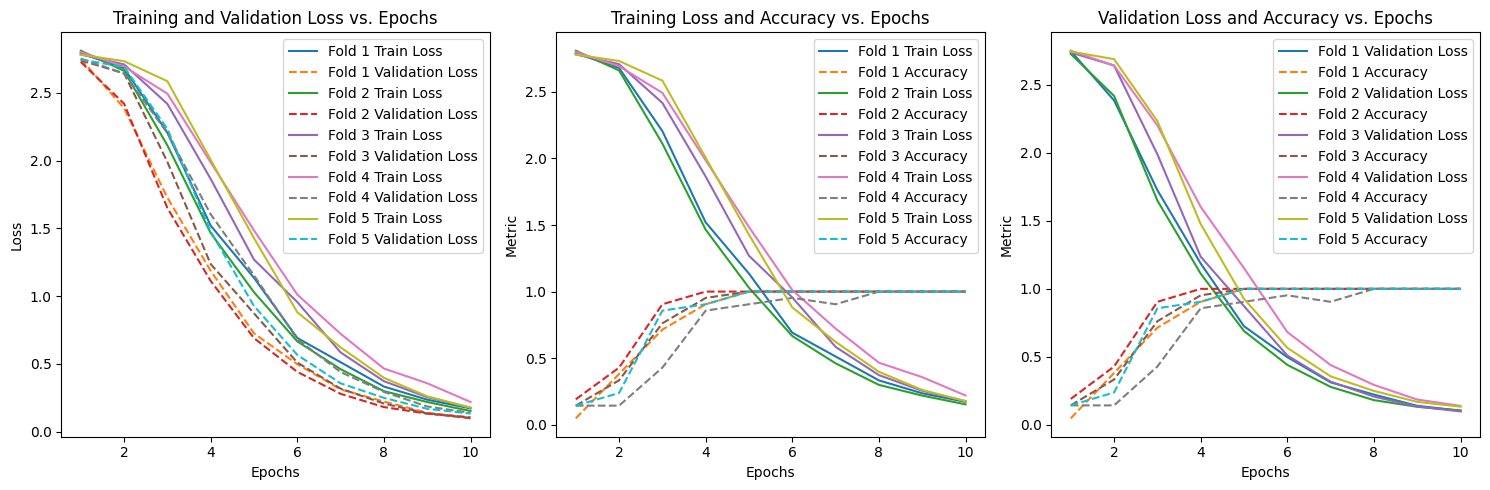

In [6]:
# Plotting the results
import matplotlib.pyplot as plt
def plot_metrics(all_folds_metrics):
    # Plot Training and Validation Loss vs. Epochs
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    for i, df in enumerate(all_folds_metrics, start=1):
        plt.plot(df['Epoch'], df['Train Loss'], label=f'Fold {i} Train Loss')
        plt.plot(df['Epoch'], df['Validation Loss'], label=f'Fold {i} Validation Loss', linestyle='--')
    plt.title('Training and Validation Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training Loss and Accuracy vs. Epochs
    plt.subplot(1, 3, 2)
    for i, df in enumerate(all_folds_metrics, start=1):
        plt.plot(df['Epoch'], df['Train Loss'], label=f'Fold {i} Train Loss')
        plt.plot(df['Epoch'], df['Accuracy'], label=f'Fold {i} Accuracy', linestyle='--')
    plt.title('Training Loss and Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()

    # Plot Validation Loss and Accuracy vs. Epochs
    plt.subplot(1, 3, 3)
    for i, df in enumerate(all_folds_metrics, start=1):
        plt.plot(df['Epoch'], df['Validation Loss'], label=f'Fold {i} Validation Loss')
        plt.plot(df['Epoch'], df['Accuracy'], label=f'Fold {i} Accuracy', linestyle='--')
    plt.title('Validation Loss and Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Generate the plots
plot_metrics(all_folds_metrics)

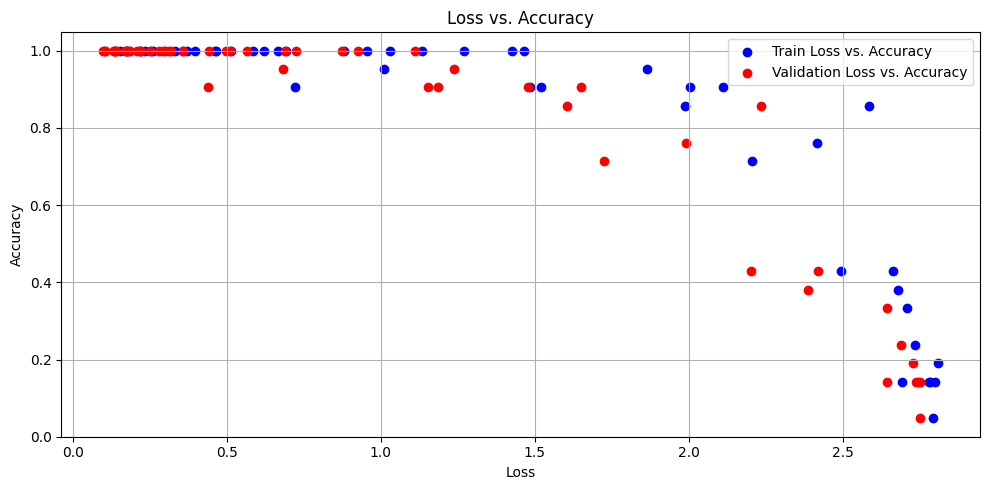

In [7]:
import matplotlib.pyplot as plt

# Plot Training Loss vs. Accuracy and Validation Loss vs. Accuracy
def plot_loss_vs_accuracy(all_folds_metrics):
    plt.figure(figsize=(10, 5))

    # Extract the metrics from all folds
    train_loss = []
    val_loss = []
    accuracy = []

    for df in all_folds_metrics:
        train_loss.extend(df['Train Loss'].tolist())
        val_loss.extend(df['Validation Loss'].tolist())
        accuracy.extend(df['Accuracy'].tolist())

    # Plot Training Loss vs. Accuracy
    plt.scatter(train_loss, accuracy, c='blue', label='Train Loss vs. Accuracy')
    plt.title('Loss vs. Accuracy')
    plt.xlabel('Loss')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Plot Validation Loss vs. Accuracy
    plt.scatter(val_loss, accuracy, c='red', label='Validation Loss vs. Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Generate the plots
plot_loss_vs_accuracy(all_folds_metrics)


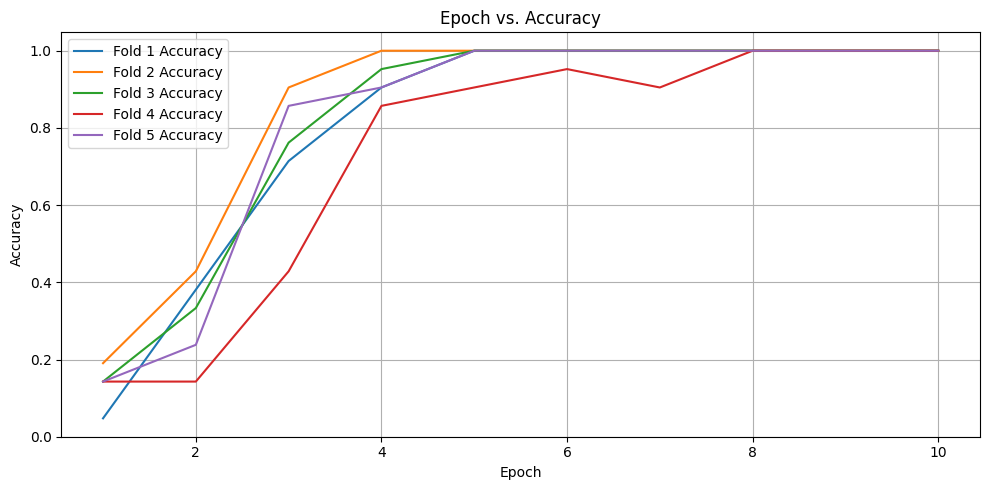

In [8]:
import matplotlib.pyplot as plt

# Plot Epoch vs. Accuracy
def plot_epoch_vs_accuracy(all_folds_metrics):
    plt.figure(figsize=(10, 5))

    for i, df in enumerate(all_folds_metrics, start=1):
        plt.plot(df['Epoch'], df['Accuracy'], label=f'Fold {i} Accuracy')
    
    plt.title('Epoch vs. Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Generate the plot
plot_epoch_vs_accuracy(all_folds_metrics)


In [13]:
# Function to get a response from the model
def get_response(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()
    intent = label_encoder.inverse_transform([predicted_class_id])[0]
    response = random.choice(responses_dict[intent])
    return response

# Interactive chat
print("Start chatting with the bot (type 'quit' to stop)!")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    response = get_response(user_input)
    print(f"Bot: {response}")

Start chatting with the bot (type 'quit' to stop)!


You:  hi


Bot: Hey! How can I help?


You:  tell me more on disability support


Bot: If you have a disability, or care for someone with a disability, you may be eligible for a Study Needs Agreement (SNA). A SNA identifies the adjustment and support that should be made for you. This could include adjustments for when you take exams (if they're part of your programme), mentoring and any specialist equipment you may need. Many students at Herts have a SNA. A SNA will help us identify how we can help and support you throughout your time at Herts.Find out more about SNAs. [https://ask.herts.ac.uk/study-needs-agreement-sna]


You:  what is student wellbeing 


Bot: If your studies are affecting your mental health and wellbeing then pleasecontact our Student Wellbeing team [https://ask.herts.ac.uk/student-wellbeing]for support. You can alsocall our free 24/7 wellbeing helpline [https://ask.herts.ac.uk/student-wellbeing-24-hour-helpline]ran by Health Assured whenever you need to. You can also talk to staff in your School if you’re struggling.


You:  im suffering from mental health


Bot: If your studies are affecting your mental health and wellbeing then pleasecontact our Student Wellbeing team [https://ask.herts.ac.uk/student-wellbeing]for support. You can alsocall our free 24/7 wellbeing helpline [https://ask.herts.ac.uk/student-wellbeing-24-hour-helpline]ran by Health Assured whenever you need to. You can also talk to staff in your School if you’re struggling.


You:  quit


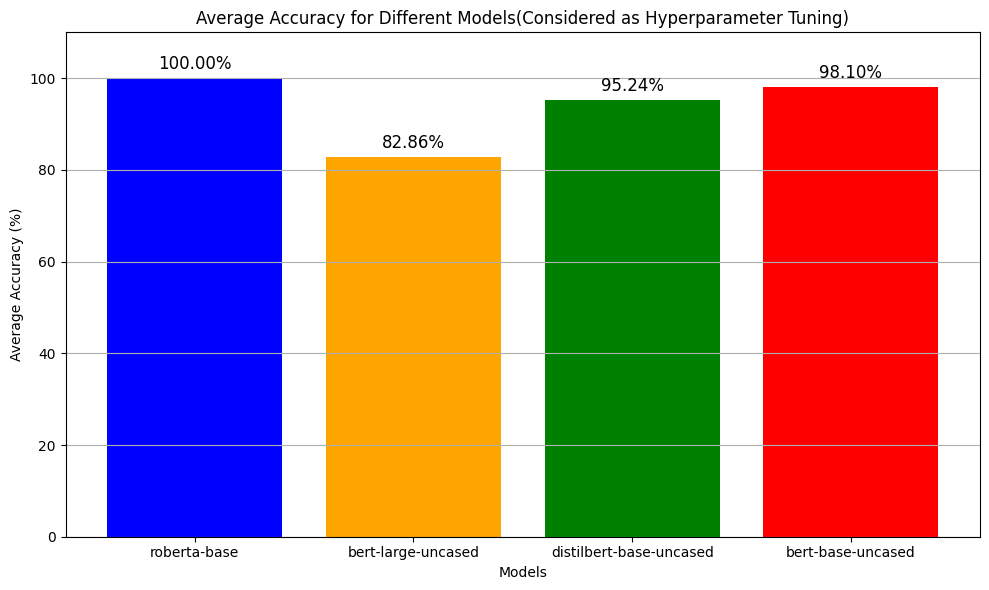

In [13]:
import matplotlib.pyplot as plt

# Data for the plot
models = ['roberta-base', 'bert-large-uncased', 'distilbert-base-uncased', 'bert-base-uncased']
average_accuracies = [100.00, 82.86, 95.24, 98.10]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, average_accuracies, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 110)  # Set y-axis limit slightly above 100 for better visualization
plt.title('Average Accuracy for Different Models(Considered as Hyperparameter Tuning)')
plt.xlabel('Models')
plt.ylabel('Average Accuracy (%)')
plt.grid(axis='y')

# Adding the accuracy values on top of the bars
for i, acc in enumerate(average_accuracies):
    plt.text(i, acc + 2, f"{acc:.2f}%", ha='center', fontsize=12)

plt.tight_layout()

plt.savefig('BertPyTorch.png', format='png')

plt.show()
